In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

Using device:  cuda


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [6]:
class SecNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnnmodel = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        self.fullyconn = nn.Sequential(
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.cnnmodel(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconn(x)
        return x

net = SecNet().to(device)

In [7]:
import torch.optim as optim

lr = 0.001
momentum = 0.9
epochs = 50

crit = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=lr)
# opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

In [8]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/training_loss_50_epoch')

In [9]:
for epoch in range(epochs):
    loss_arr = []
    for i, data in enumerate(trainloader, 0):
        inputs, labels = (item.to(device) for item in data)
        opt.zero_grad()
        outputs = net(inputs)
        loss = crit(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        
        # if i % 2000 == 1999: # print every 2000 mini batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0
        # plt.plot(loss_arr)
        # plt.title("Training loss")
        # plt.show()
        global_step = epoch * len(trainloader) + i
        writer.add_scalar('Loss/train', loss.item(), global_step)

writer.close()

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images
labels = labels

net = SecNet()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

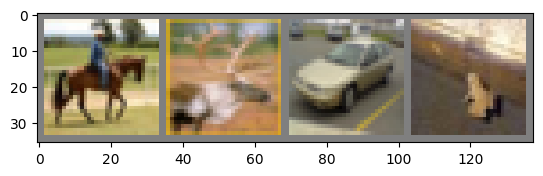

GroundTruth:  horse deer  car   frog 


In [18]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [19]:
outputs = net(images)

In [20]:
_, pred = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[pred[j]]:5s}' for j in range(4)))

Predicted:  horse deer  car   cat  


In [21]:
correct = 0
total = 0
# We dont need to calc grads since we are not training
with torch.no_grad():
    for data in testloader:
        img, lab = data
        out = net(img)
        # Class with highest energy is what we choose
        _, pred = torch.max(out, 1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

print(f'Accuracy on 10000 test images: {100 * correct // total} %')

Accuracy on 10000 test images: 60 %


In [ ]:
import torch.onnx

torch.onnx.export(net, images[1], 'net.onnx', verbose=True)